In [2]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

EFASDIR_HIST="/home/zappa/work_big/EFAS/output"

# Open a NetCDF file
fname="{EFASDIR_HIST}/efas_italy_2016.nc"

dataset = xr.open_dataset(f"{EFASDIR_HIST}/efas_italy_2016.nc")


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 1464, lon: 722, lat: 722)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2016-01-01T06:00:00 ... 2017-01-01
  * lon      (lon) float64 6kB 7.992 8.008 8.025 8.042 ... 19.98 19.99 20.01
  * lat      (lat) float64 6kB 48.01 47.99 47.98 47.96 ... 36.02 36.01 35.99
Data variables:
    dis06    (time, lat, lon) float32 3GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Sun Mar 10 03:36:56 2024: cdo -f nc copy mars_data_0.grib o...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...


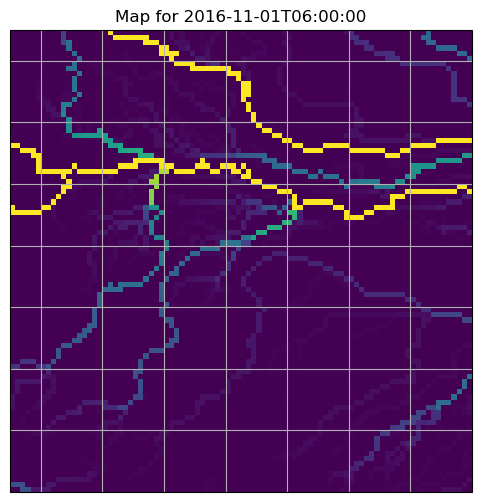

In [3]:

# Print the dataset to see its structure
print(dataset)

# Access variables within the dataset
variable = dataset['dis06']


# Select the data for the specific time step you want to plot
time_step = '2016-11-01T06:00:00'  # Example time step
data_for_time_step = dataset.sel(time=time_step)

# Extract longitude, latitude, and variable data
lon = data_for_time_step['lon']
lat = data_for_time_step['lat']
variable = data_for_time_step['dis06']  # Replace 'your_variable' with the name of your variable

# Plot the map
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the variable on the map
plt.pcolormesh(lon, lat, variable, transform=ccrs.PlateCarree(), cmap='viridis',vmin=0,vmax=25)
plt.xlim(10.5, 12)  # Set longitude range
plt.ylim(44, 45.5)  # Set latitude range

# Add coastlines, gridlines, and title
ax.coastlines()
ax.gridlines()
plt.title(f'Map for {time_step}')

plt.show()


# Close the dataset when you're done
# dataset.close()

# extract time series Panaro